In [1]:
pip install -q -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np

from statsforecast import StatsForecast

import time
from statsforecast.models import (
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    AutoETS,
    Naive
)
from utilsforecast.losses import *
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from utilsforecast.evaluation import evaluate

from functools import partial
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM
from chronos import BaseChronosPipeline
import scipy.stats as stats 

import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from importlib import reload
import utils
reload(utils)
from utils import prepare_data, TimeMoEPredictor, chronosPredictor, LLM, wape, prophet_forecast, prophet_wrapper

from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

from statsforecast.utils import ConformalIntervals

intervals = ConformalIntervals(h=3, n_windows=5)

from multiprocessing import cpu_count, Pool # for prophet


## Prepare data

In [3]:
#train, test = prepare_data(sample_size=1000,series_cutoff=72,min_series_length=60)

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train["ds"] = pd.to_datetime(train["ds"])
test["ds"] = pd.to_datetime(test["ds"])

In [14]:
# Create a list of models and instantiation parameters
season_length = 12

models_classes_stats = [
    DOT(season_length=season_length),
    AutoARIMA(prediction_intervals=intervals),
    AutoETS(prediction_intervals=intervals),
    Naive(prediction_intervals=intervals)
]

model_classes_neural = [
    NBEATS(h=3, input_size=10,
               stack_types = ['identity', 'trend', 'seasonality'],
            )
]

model_classes_ml = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
]

model_classes_custom = [
    TimeMoEPredictor(input_length=24,device="cpu"),
    chronosPredictor(input_length=24,device="mps"),
    prophet_forecast(prophet_wrapper, train,  weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=True, interval_width=0.95 )
    ]


Seed set to 1
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
model_classes_custom

In [15]:
model_wrappers = {}
model_names = []

neural = False
stats = False
ML = False
custom = True

if ML:
    for model in model_classes_ml:
        model_name = str(model).split("(")[0]
        model_names.append(model_name)
        model_wrappers[model_name]=(
            MLForecast(
                models=model,
                freq='ME',
                #lags=[1,2,3],
                #lag_transforms={
                #    1: [ExpandingMean(),RollingMean(window_size=12),RollingMean(window_size=3),RollingMean(window_size=6),RollingMean(window_size=12)],        
                #},
                date_features=['dayofweek'],
                target_transforms=[Differences([1])],
            )
        )

if custom:
    for model in model_classes_custom:
        model_name = str(type(model).__name__)
        model_names.append(model_name)
        model_wrappers[model_name] = model

if neural:
    for model in model_classes_neural:
        model_name = str(model)
        model_names.append(model_name)
        model_wrappers[model_name]=(
            NeuralForecast( 
                models=[model],
                freq='ME'
            )
        )    

if stats:
    for model in models_classes_stats:
        model_name = str(model)
        model_names.append(model_name)
        model_wrappers[model_name]=(
            StatsForecast( 
                models=[model],
                freq="ME", 
                fallback_model = SeasonalNaive(season_length=12),
                n_jobs=-1,
            )
        )    


In [16]:
fit_times = {}

for model_name, model in model_wrappers.items():
    if isinstance(model, MLForecast):
        start = time.time()
        model.fit(df=train, prediction_intervals=intervals )
        fit_times[model_name] = time.time()-start

    elif isinstance(model, StatsForecast) or isinstance(model, NeuralForecast) or isinstance(model, prophet_forecast):
        start = time.time()
        model.fit(df=train )
        fit_times[model_name] = time.time()-start    

dict_keys(['M10000', 'M10127', 'M1013', 'M10176', 'M10280', 'M10416', 'M1042', 'M10449', 'M10756', 'M10763', 'M10766', 'M10794', 'M10852', 'M10885', 'M1100', 'M11044', 'M11055', 'M11095', 'M11100', 'M11106', 'M11278', 'M11410', 'M11429', 'M11437', 'M11474', 'M11488', 'M11531', 'M11610', 'M1164', 'M11678', 'M11708', 'M11745', 'M11785', 'M11801', 'M11874', 'M11887', 'M11902', 'M11962', 'M11990', 'M12121', 'M12187', 'M12195', 'M12214', 'M12226', 'M12319', 'M12345', 'M12437', 'M12454', 'M12464', 'M12465', 'M12466', 'M12517', 'M12564', 'M12575', 'M12586', 'M12657', 'M12676', 'M12682', 'M1276', 'M12792', 'M1285', 'M12958', 'M13037', 'M13054', 'M13205', 'M13253', 'M13340', 'M13374', 'M13380', 'M13389', 'M13410', 'M13470', 'M13525', 'M13593', 'M13661', 'M1375', 'M13799', 'M13804', 'M13836', 'M13871', 'M13892', 'M14051', 'M14254', 'M14264', 'M14293', 'M14296', 'M14304', 'M14333', 'M14346', 'M14508', 'M14536', 'M14561', 'M14570', 'M1463', 'M14703', 'M14772', 'M14776', 'M14952', 'M14997', 'M15094

DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmpcpeie78n/_5e15bk1.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmpyuit6fae/45sjnva_.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmporpf25hr/c8nnyqfw.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmpqozbyxta/9nfrcj2_.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmp_snwj4ez/xio9dabk.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmpv29y3082/ba2yhm8m.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmpcpeie78n/qebmwy1n.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmpcl9d1whp/_ckt314z.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmpyuit6fae/7k7j4tk5.json
DEBUG:cmdstanpy:input tempfile: /var/

KeyboardInterrupt: 

In [7]:
forecast_dict = {}
forecast_times = {}

levels = [95]

def add_model(forecasts,model_name):
    forecast_dict[model_name] = forecasts
    
for model_name, model in model_wrappers.items():
    print(model)
    
    start = time.time()

    if isinstance(model, NeuralForecast):
        add_model(model.predict().reset_index(),model_name)
    elif (isinstance(model,StatsForecast)) or (isinstance(model,MLForecast)):
        add_model(model.predict(h=3,level=levels),model_name)
    else:
        add_model(model.predict(train,test,h=3),model_name)
        fit_times[model_name] = time.time()-start

    forecast_times[model_name] = time.time()-start


MLForecast(models=[LGBMRegressor], freq=ME, lag_features=[], date_features=['dayofweek'], num_threads=1)
MLForecast(models=[LinearRegression], freq=ME, lag_features=[], date_features=['dayofweek'], num_threads=1)
969


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 31/31 [00:00<00:00, 179.71it/s]
StatsForecast(models=[DynamicOptimizedTheta])


/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


StatsForecast(models=[AutoARIMA])
StatsForecast(models=[AutoETS])
StatsForecast(models=[Naive])


In [8]:
forecast_times

{'LGBMRegressor': 0.010331153869628906,
 'LinearRegression': 0.003817319869995117,
 'TimeMoEPredictor': 5.14327073097229,
 'chronosPredictor': 0.46426820755004883,
 'NBEATS': 0.22286415100097656,
 'DynamicOptimizedTheta': 5.070374011993408,
 'AutoARIMA': 1.8554370403289795,
 'AutoETS': 1.8355300426483154,
 'Naive': 1.8960769176483154}

In [9]:
train

,unique_id,y,ds
0,M10000,5320.0,2011-04-30 12:00:00
1,M10000,5700.0,2011-05-31 12:00:00
2,M10000,6960.0,2011-06-30 12:00:00
3,M10000,7200.0,2011-07-31 12:00:00
4,M10000,4990.0,2011-08-31 12:00:00
...,...,...,...
69760,M9964,700.0,2016-08-31 12:00:00
69761,M9964,630.0,2016-09-30 12:00:00
69762,M9964,630.0,2016-10-31 12:00:00
69763,M9964,610.0,2016-11-30 12:00:00


In [10]:
weights = (
    train
        .groupby("unique_id",)["y"]
        .sum()
        .rename("weights")
)

weights = weights/weights.sum()

In [11]:
metrics = [
    mape,
    wape,
    rmse,
    partial(mase, seasonality=12),
    partial(rmsse, seasonality=12),
]

In [12]:
test = test.reset_index()

for name,forecast in forecast_dict.items():
    test = test.merge(forecast, on = ["ds","unique_id"],how="inner")

In [13]:
(
    test
        .filter(regex='95|index')
        .melt(id_vars="index")
        .assign(
            model=lambda x: x["variable"].str.split("-", n=1, expand=True)[0],
            d=lambda x: x["variable"].str.split("-", n=1, expand=True)[1]
        )
        .pivot(index = ["index","model"], columns="d",values="value")
        .assign(
            width = lambda x : x["hi-95"]-x["lo-95"]
        )
        .groupby(["model"])["width"]
        .median()
        .sort_values()
)

model
AutoARIMA                571.000000
AutoETS                  591.019999
Naive                    615.495000
LinearRegression         617.653038
LGBMRegressor            617.741614
DynamicOptimizedTheta    739.168213
Name: width, dtype: float64

In [14]:
eval = evaluate(test, metrics=metrics, train_df=train)

In [15]:
eval[eval["metric"]=='wape']

,unique_id,metric,index,LGBMRegressor,LinearRegression,TimeMoEPredictor,chronosPredictor,NBEATS,DynamicOptimizedTheta,AutoARIMA,AutoETS,Naive
969,M10000,wape,36.333333,0.072609,0.076567,0.209031,0.175989,0.175768,0.075334,0.123036,0.075875,0.075881
970,M10127,wape,6.830986,0.024871,0.012295,0.020023,0.013426,0.007728,0.006077,0.005288,0.004097,0.010909
971,M1013,wape,10.121495,0.181976,0.184218,0.220727,0.119385,0.220666,0.436060,0.474084,0.439833,0.184932
972,M10176,wape,10.767016,0.070086,0.067372,0.062621,0.064004,0.061165,0.008154,0.073792,0.066508,0.066508
973,M10280,wape,20.009311,0.006015,0.002778,0.005522,0.011573,0.002932,0.002676,0.003509,0.002578,0.002577
...,...,...,...,...,...,...,...,...,...,...,...,...
1933,M9825,wape,0.959220,0.126604,0.134492,0.065976,0.090920,0.132067,0.248001,0.202481,0.239880,0.133333
1934,M983,wape,0.915073,0.038179,0.036722,0.035509,0.016283,0.033039,0.012857,0.036257,0.036268,0.036257
1935,M9922,wape,0.988222,0.192064,0.177901,0.108199,0.171973,0.098475,0.180159,0.172509,0.180002,0.180000
1936,M9942,wape,0.978477,0.135413,0.126611,0.142813,0.119430,0.120024,0.110564,0.077071,0.124370,0.127907


In [16]:
eval.drop(columns=["index"]).set_index(["unique_id","metric" ]).stack().reset_index().set_index(["unique_id",'metric', 'level_2']).unstack(level=1).corr()

0                                        
metric        mape      mase      rmse     rmsse      wape
  metric                                                  
0 mape    1.000000  0.216780  0.440920  0.190769  0.373647
  mase    0.216780  1.000000  0.433201  0.959791  0.393751
  rmse    0.440920  0.433201  1.000000  0.456485  0.743128
  rmsse   0.190769  0.959791  0.456485  1.000000  0.400388
  wape    0.373647  0.393751  0.743128  0.400388  1.000000

In [17]:
eval.drop(columns=["index"]).set_index(["unique_id","metric" ]).stack().reset_index().set_index(["unique_id",'metric', 'level_2']).unstack(level=1).describe()

0                                                     
metric         mape         mase          rmse        rmsse         wape
count   8721.000000  8721.000000   8721.000000  8721.000000  8721.000000
mean       0.139915     0.769892    509.861268     0.684407     0.110519
std        0.468583     1.015054   1267.034039     0.898897     0.239351
min        0.000000     0.000000      0.000000     0.000000     0.000000
25%        0.013568     0.216205     54.786310     0.199855     0.013693
50%        0.039242     0.470860    155.164445     0.429298     0.039620
75%        0.118451     0.940032    425.715085     0.857391     0.118360
max       10.969641    15.865282  19768.353738    11.888380     6.810264

In [18]:
metrics = eval.drop(columns="index").set_index(["unique_id","metric"]).stack().rename_axis(index={None: 'Model'}).rename("value")

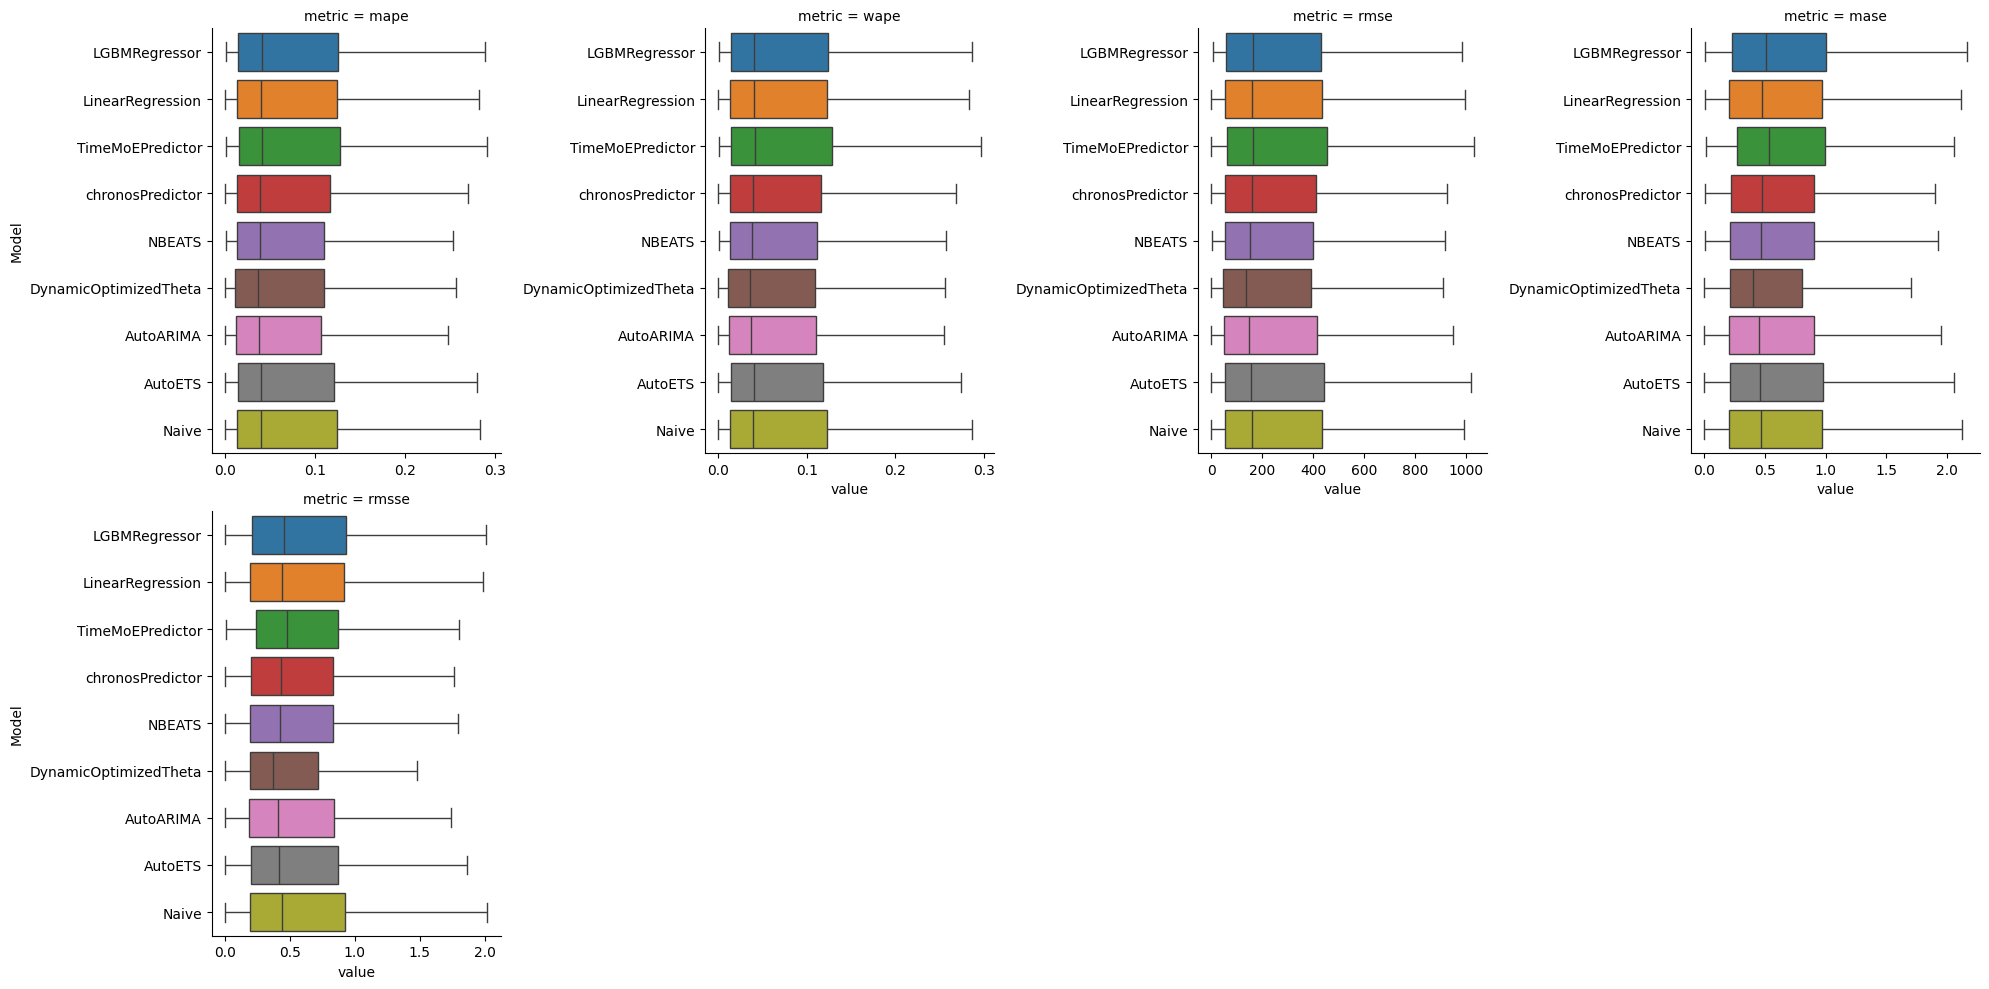

In [19]:
sns.catplot(
    data=metrics.reset_index(), x='value', y='Model',hue="Model",sharey=False,sharex=False,showfliers=False,
    col='metric', kind='box', col_wrap=4
)

In [20]:
fit_times = pd.DataFrame.from_records([fit_times])
forecast_times = pd.DataFrame.from_records([forecast_times])

In [21]:
fit_times = fit_times.melt(var_name="Model",value_name="fit").set_index("Model")

forecast_times = forecast_times.melt(var_name="Model",value_name="forecast").set_index("Model")

In [22]:
metrics.groupby(level=[1,2]).median().unstack()

Model,AutoARIMA,AutoETS,DynamicOptimizedTheta,LGBMRegressor,LinearRegression,NBEATS,Naive,TimeMoEPredictor,chronosPredictor
metric,,,,,,,,,
mape,0.038022,0.040017,0.036290,0.040757,0.040064,0.038647,0.039860,0.041025,0.039025
mase,0.451332,0.455951,0.402664,0.504213,0.472293,0.466421,0.470831,0.535186,0.476092
rmse,146.618518,156.781555,137.277278,162.878968,160.744854,153.660721,159.613074,162.429456,159.311272
rmsse,0.405601,0.415875,0.368366,0.454822,0.438558,0.425984,0.436447,0.479285,0.432216
wape,0.037687,0.040436,0.035694,0.040375,0.040444,0.037918,0.040000,0.041678,0.039676


In [23]:
md = metrics.groupby(level=[1,2]).median().to_frame().join(fit_times).join(forecast_times).set_index("value",append=True).stack().rename_axis(index={None: 'time'}).rename("time_value").reset_index()

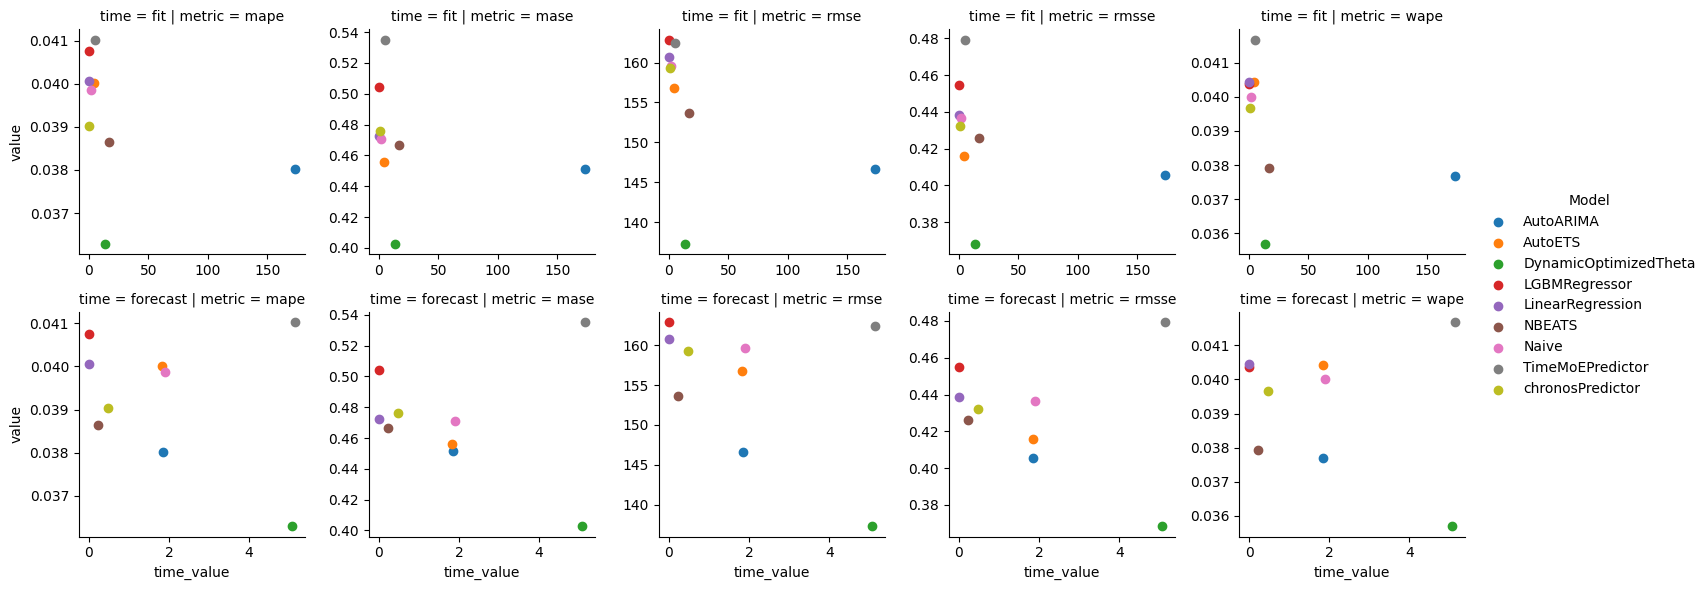

In [24]:
g = sns.FacetGrid(md, row= "time", col="metric", hue = "Model",sharey=False,sharex=False)
g = g.map(plt.scatter, "time_value", "value")
g.add_legend()

In [25]:
(
    metrics
        #[metrics.index.get_level_values(level=1).isin(["rmsse","rmse","mape","wape"])]
        .reset_index().merge(weights, on = "unique_id")
        .assign(metric = lambda x : "w"+x["metric"],
                value = lambda x : x.value*x.weights
                )
        .groupby(["metric","Model"])["value"]
        .sum()
        .sort_values()
        .unstack(level=0)
        .reset_index()
        .sort_values(by="wrmsse")
)

metric,Model,wmape,wmase,wrmse,wrmsse,wwape
2,DynamicOptimizedTheta,0.120688,0.600582,613.759798,0.544013,0.091168
8,chronosPredictor,0.121273,0.704331,640.296713,0.635842,0.099868
5,NBEATS,0.112358,0.720838,613.410762,0.648214,0.099621
7,TimeMoEPredictor,0.121018,0.723950,637.809390,0.648701,0.098379
0,AutoARIMA,0.114842,0.727207,617.366828,0.656617,0.094519
1,AutoETS,0.129443,0.780702,676.247635,0.696517,0.099867
6,Naive,0.136250,0.807610,714.785956,0.721112,0.111585
4,LinearRegression,0.136236,0.810050,714.958679,0.722803,0.111693
3,LGBMRegressor,0.136912,0.825170,716.663056,0.734934,0.112219


In [26]:
df = metrics.unstack(level=1).reset_index().drop(columns=["unique_id"])

In [27]:
from itertools import product
from scipy import stats
import pandas as pd

cols = df.columns.difference(['Model'])

g = df.groupby('Model')[cols]

out = pd.concat({(a, b): pd.DataFrame(stats.ttest_rel(g.get_group(a), g.get_group(b),alternative="less"),
                                      columns=cols, index=['statistic', 'pvalue'])
                 for a, b in product(df['Model'].unique(), repeat=2)
                }, names=['product1', 'product2'])


<Axes: xlabel='None-product2', ylabel='product1-metric'>

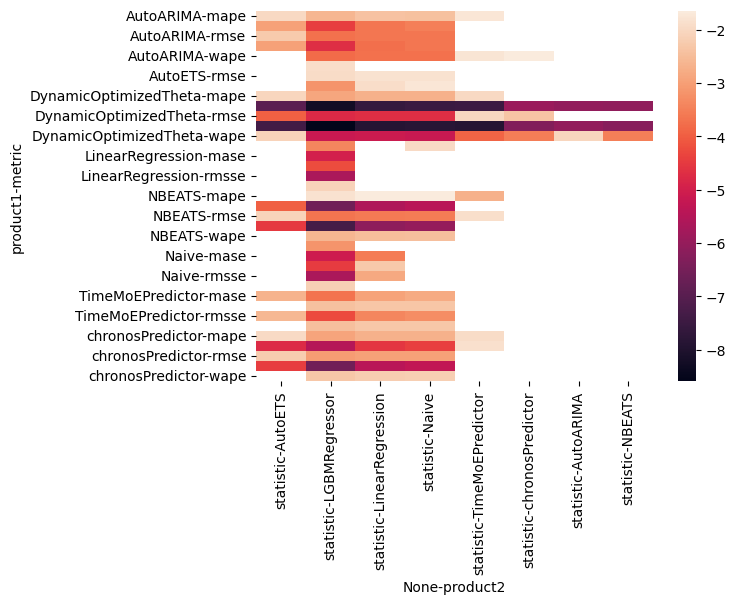

In [28]:
sns.heatmap(out.stack().unstack(level=2).loc[lambda x : x.pvalue <0.05].drop(columns="pvalue").unstack(level=1))